In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import importlib
import ferbo as fb
from tqdm.notebook import tqdm
importlib.reload(fb)
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
from utils import plot_vs_parameters
from theory import eingensystem_hamiltonian
import matplotlib.colors as mcolors

In [8]:
Ej = 1
Ec = 5
r = 0.05
Nmax = 10

dimension = 2 * (2 * Nmax + 1)
q_list = np.linspace(-1/4, 1/4, 201)
eigvals_list = np.zeros((len(q_list), dimension))
bloch_vector_list = np.zeros((len(q_list), dimension, dimension), dtype=complex)

for i, q in enumerate(q_list):
        eigvals_list[i], bloch_vector_list[i] = eingensystem_hamiltonian(Ej, r, Ec, q, Nmax)

derivate_bloch_vector_list = np.gradient(bloch_vector_list, q_list, axis=0)
Omega_tensor = 1j * np.einsum('qln,qlm->qnm', np.conjugate(bloch_vector_list), derivate_bloch_vector_list)

N_list = -np.arange(-Nmax, Nmax + 1)
n, m = np.meshgrid(N_list, N_list, indexing='ij')
idx_distint = (n != m)
product_matrix = np.zeros_like(n, dtype=np.float64)
product_matrix[idx_distint] = -2 * ((-1.0) ** (n - m))[idx_distint] / (n - m)[idx_distint]

Phi_tensor = np.zeros_like(Omega_tensor)
bloch_vector_ordered_list = bloch_vector_list.reshape(len(q_list), -1, dimension, 2)
Phi_tensor = 1j * np.einsum('qmas,mn,qnbs->qab', np.conjugate(bloch_vector_ordered_list), product_matrix, bloch_vector_ordered_list)

1


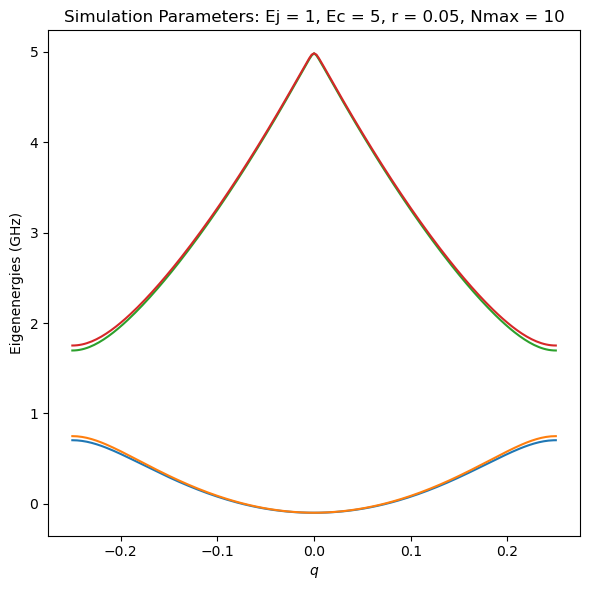

In [9]:
ylabel = 'Eigenenergies (GHz)'
title = f'Simulation Parameters: Ej = {Ej}, Ec = {Ec}, r = {r}, Nmax = {Nmax}'
parameter_name = r'$q$'
plot_vs_parameters(q_list,eigvals_list[:, :4],parameter_name,ylabel,title)

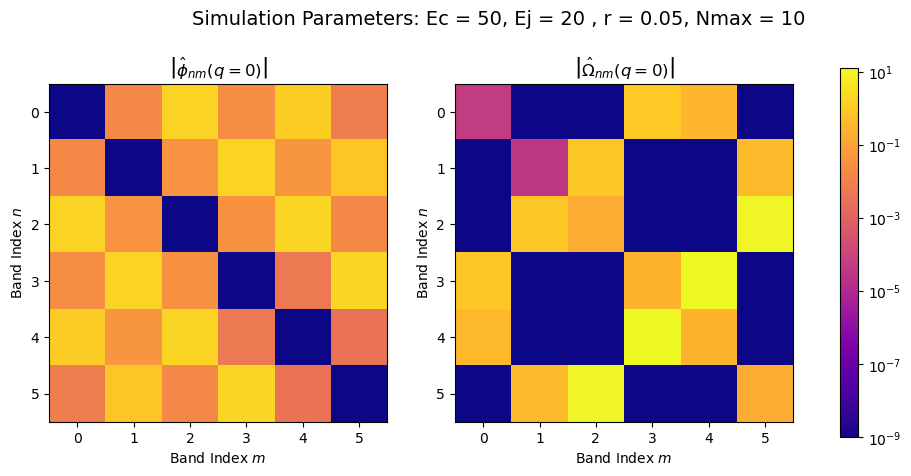

In [10]:
q_index = 3
n_index = slice(0, 6)
m_index = slice(0, 6)

# Calculate the minimum positive value greater than zero across both matrices
# min_positive = min(
#     np.min(np.abs(Phi_tensor[q_index, n_index, m_index])[np.abs(Phi_tensor[q_index, n_index, m_index]) > 0]),
#     np.min(np.abs(Omega_tensor[q_index, n_index, m_index])[np.abs(Omega_tensor[q_index, n_index, m_index]) > 0])
# )

min_positive = 1e-9

# Calculate the maximum value across both matrices
max_value = max(
    np.max(np.abs(Phi_tensor[q_index, n_index, m_index])),
    np.max(np.abs(Omega_tensor[q_index, n_index, m_index]))
)

# Create a common normalization with the minimum positive and maximum values
norm = mcolors.LogNorm(vmin=min_positive, vmax=max_value)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
im1 = ax[0].imshow(np.abs(Phi_tensor[q_index, n_index, m_index]), cmap='plasma', norm=norm)
ax[0].set_title(r'$\left| \hat\phi_{nm} (q = 0)\right|$')
ax[0].set_xlabel(r'Band Index $m$')
ax[0].set_ylabel(r'Band Index $n$')

# Second subplot
im2 = ax[1].imshow(np.abs(Omega_tensor[q_index, n_index, m_index]), cmap='plasma', norm=norm)
ax[1].set_title(r'$\left| \hat\Omega_{nm} (q = 0)\right| $')
ax[1].set_xlabel(r'Band Index $m$')
ax[1].set_ylabel(r'Band Index $n$')

# Add a common colorbar for both subplots, adjusting its size to match the matrices
cbar = fig.colorbar(im1, ax=ax.ravel().tolist(), orientation='vertical', shrink=0.8)
fig.suptitle(f'Simulation Parameters: Ec = {Ec}, Ej = {Ej} , r = {r}, Nmax = {Nmax}', fontsize=14, y = 0.9)

# Display the figure
plt.show()